# Get images as (anchor, second_image, label)
1 if second image is positive, 0 if negative

In [1]:
import os 

TRAIN_PATH = r"C:\Users\holog\Desktop\machine_learning\similarity\train"
TEST_PATH = r"C:\Users\holog\Desktop\machine_learning\similarity\test"

positive_pairs_train = []
negative_pairs_train = []

# Anchor images are in train/directory/anchor for each directory
for category in os.listdir(TRAIN_PATH):
    anchor_dir = os.path.join(TRAIN_PATH, category, "anchor")
    positive_dir = os.path.join(TRAIN_PATH, category, "positive")
    negative_dir = os.path.join(TRAIN_PATH, category, "negative")

    anchor_list = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir)]
    positive_list = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir)]
    negative_list = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir)]

    # Within each category directory, match each anchor with each positive and negative 
    positive_pairs_train += [(a, p, 1) for a in anchor_list for p in positive_list]
    negative_pairs_train += [(a, n, 0) for a in anchor_list for n in negative_list]

data_raw_train = positive_pairs_train + negative_pairs_train 

# Do the same for test images
positive_pairs_test = []
negative_pairs_test = []

test_path_positive = os.path.join(TEST_PATH, "positive")
test_path_negative = os.path.join(TEST_PATH, "negative")

for category in os.listdir(test_path_positive):
    dirs = os.listdir(os.path.join(test_path_positive, category))
    first_dir = os.path.join(test_path_positive, category, dirs[0])
    second_dir = os.path.join(test_path_positive, category, dirs[1])
    positive_pairs_test.append((category, first_dir, second_dir, 1))

for category in os.listdir(test_path_negative):
    dirs = os.listdir(os.path.join(test_path_negative, category))
    first_dir = os.path.join(test_path_negative, category, dirs[0])
    second_dir = os.path.join(test_path_negative, category, dirs[1])
    negative_pairs_test.append((category, first_dir, second_dir, 0))

data_raw_test = positive_pairs_test + negative_pairs_test

data_raw_test

[('earbuds_untrained_different_environment',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\earbuds_untrained_different_environment\\20250131_030103.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\earbuds_untrained_different_environment\\20250131_030121.jpg',
  1),
 ('light_untrained_positive',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\light_untrained_positive\\20250131_025753.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\light_untrained_positive\\20250131_025818.jpg',
  1),
 ('mouse_untrained_positive',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\mouse_untrained_positive\\20250129_125729.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\mouse_untrained_positive\\20250131_014405.jpg',
  1),
 ('pen_trained_positive',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\test\\positive\\p

# Preprocess images

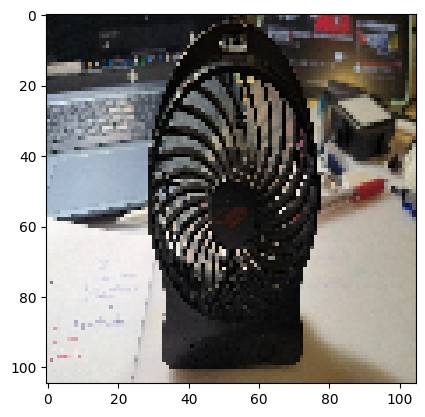

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt 

def preprocess(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))  # Resize to 105x105x3 (3 color channels)
    img = img / 255.0  # Scale image between 0 and 1
    return img 

# The first anchor image is shown
test = preprocess(data_raw_train[0][0])
plt.imshow(test)

# Create labelled dataset (1 and 0)

In [3]:

# Convert to tf dataset 
def convert_to_tf_dataset(data_raw):
    i1_paths, i2_paths, labels = zip(*data_raw)
    i1_dataset = tf.data.Dataset.from_tensor_slices(list(i1_paths)).map(preprocess)  # Preprocess the images 
    i2_dataset = tf.data.Dataset.from_tensor_slices(list(i2_paths)).map(preprocess)
    label_dataset = tf.data.Dataset.from_tensor_slices(list(labels))

    dataset = tf.data.Dataset.zip((i1_dataset, i2_dataset, label_dataset))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1024)

    return dataset

0


<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

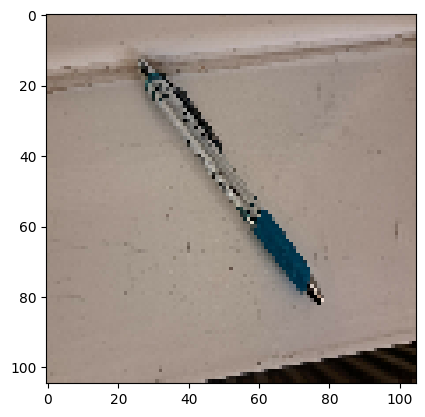

In [4]:
# Convert to tf dataset 
dataset_train = convert_to_tf_dataset(data_raw_train)

# Check 
samples = dataset_train.as_numpy_iterator()
next = samples.next()
print(next[2])  # next[0] is the anchor, next[1] is the positive, next[2] is the negative
# Hence, if 1 is printed, the image is positive, else the image should be negative:
plt.imshow(next[1])

# Should show a different image everytime 
dataset_train  

# Create the train_data

In [5]:
# Number of anchors in each anchor dir * (Number of positives in each positive dir + Number of negatives in each negative dir) * Number of categories
print(len(dataset_train))

BATCH_SIZE = 2

train_data = dataset_train.take((len(dataset_train)))  # Take all train data
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(8)

# Check
train_sample = train_data.as_numpy_iterator().next()
print(train_data)
print(len(train_sample))  # 3
print(len(train_sample[0]))  # = BATCH_SIZE

54
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
3
2


# Build embedding layer

In [6]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Lambda

def make_embedding():
    inp = Input(shape=(105, 105, 3))

    c1 = Conv2D(64, (10, 10), activation="relu")(inp)  # Convolution + ReLU
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)  # Max pooling

    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = "sigmoid")(f1)   # Fully connected layer 

    return Model(inputs=[inp], outputs = [d1], name = "embedding")

# Create model
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

# Build distance layer

In [7]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # L1 distance (Similarity calculation)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()

# Make siamese model

In [8]:
def make_siamese_model():
    # Get the input images
    input_image = Input(name="input_img", shape=(105, 105, 3))
    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"

    # embedding() outputs a 4096 length array of feature vectors
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Compute L1 distance
    output = Lambda(lambda x: tf.reduce_sum(tf.abs(x), axis=-1, keepdims=True))(distances)
    # classifier = Dense(1, activation="sigmoid")(distances)
    
    # Return the siamese model
    model = Model(inputs=[input_image, validation_image], outputs=output, name="SiameseNetwork")
    return model 


# First goes through embedding (Hidden) layers, then passed to distance layer and finally dense (output) layer 
siamese_model = make_siamese_model()
siamese_model.summary()
    

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Set up loss and optimiser

In [9]:
# binary_cross_loss = tf.losses.BinaryCrossentropy()    # Loss function is binary cross entropy
opt = tf.keras.optimizers.Adam(1e-4)   # Learning rate = 0.001

margin = 1.0
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y true (Int) to float 32
    loss = (1-y_true)*tf.square(y_pred) + y_true*tf.square(tf.maximum(margin-y_pred, 0))
    return tf.reduce_mean(loss)

# Set up Tensorboard

In [10]:
import tensorflow as tf
from datetime import datetime

current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_dir = f"logs/train_{current_datetime}"
summary_writer = tf.summary.create_file_writer(log_dir)

# Establish checkpoints

In [11]:
import os 

checkpoint_dir = r"C:\Users\holog\Desktop\machine_learning\similarity\training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)  # siamese_model is the model created above 


# Build train step function
used to train one batch of data

In [12]:
# siamese_model is the model created above 

# Compile this function into tensorflow graph (@tf.function)
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]  # [anchor, positive] or [anchor, negative]
        y = batch[2]   # The label (0 or 1)

        # Pass this to the siamese neural network 
        yhat = siamese_model(X, training=True)  # Predicted y, i.e. y-hat  (y^)
        
        # Calculate loss using contrastive loss
        loss = contrastive_loss(y, yhat)

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and then apply to the siamese model
    opt.apply_gradients(
        zip(grad, siamese_model.trainable_variables)
    )

    # return the loss 
    return loss

# Build training loop

In [13]:
def train(data, EPOCHS):
    # For each epoch, loop through each batch and run train steps 
    for epoch in range(1, EPOCHS+1):
        print(f"Epoch {epoch} of {EPOCHS}" + "\n")
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for index, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(index + 1)

            # Log to tensorboard
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=epoch * len(data) + index)
        
        # Save checkpoints 
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # "ckpt"

        # Flush tensorboard
        summary_writer.flush()

# Train the model

In [14]:
EPOCHS = 20

# Train model here 
train(train_data, EPOCHS)

Epoch 1 of 20

27/27 [==============================] - 7s 134ms/step
Epoch 2 of 20

27/27 [==============================] - 4s 138ms/step
Epoch 3 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 4 of 20

27/27 [==============================] - 4s 138ms/step
Epoch 5 of 20

27/27 [==============================] - 4s 138ms/step
Epoch 6 of 20

27/27 [==============================] - 4s 138ms/step
Epoch 7 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 8 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 9 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 10 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 11 of 20

27/27 [==============================] - 4s 147ms/step
Epoch 12 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 13 of 20

27/27 [==============================] - 4s 140ms/step
Epoch 14 of 20

27/27 [==============================] - 4s 139ms/step
Epoch 15 of 20


# Evaluate the model
precision: How many positive predictions are correct
recall: How many positive results are predicted correctly.

A higher number is a better performance

In [15]:
# Import precision and recall 
from tensorflow.keras.metrics import Precision, Recall 

# Initialise precision and recall
precision = Precision()
recall = Recall()

In [16]:
# Run the model on the test data 
for (category, test_image_1, test_image_2, label) in data_raw_test:
    p1 = tf.expand_dims(preprocess(test_image_1), axis = 0)   # Make the batch size 1
    p2 = tf.expand_dims(preprocess(test_image_2), axis = 0)

    # Make predictions and compare to ground truth
    yhat = siamese_model.predict([p1, p2])
    y_true = tf.convert_to_tensor([label], dtype=tf.float32)

    # Postprocess them based on a threshold 
    THRESHOLD = 0.5 

    print(f"{category}: Expected = {label}")
    print(f"Predicted: {yhat >= THRESHOLD}")
    print(f"Confidence: {yhat}")

    # Update the precision and recall value 
    precision.update_state(y_true, yhat)
    recall.update_state(y_true, yhat)

1/1 [==============================] - 1s 829ms/step
earbuds_untrained_different_environment: Expected = 1
Predicted: [[ True]]
Confidence: [[0.790663]]
1/1 [==============================] - 0s 23ms/step
light_untrained_positive: Expected = 1
Predicted: [[ True]]
Confidence: [[0.57930565]]
1/1 [==============================] - 0s 17ms/step
mouse_untrained_positive: Expected = 1
Predicted: [[ True]]
Confidence: [[0.74815303]]
1/1 [==============================] - 0s 22ms/step
pen_trained_positive: Expected = 1
Predicted: [[ True]]
Confidence: [[0.7734297]]
1/1 [==============================] - 0s 19ms/step
stand_untrained_different_image_size: Expected = 1
Predicted: [[ True]]
Confidence: [[0.5593364]]
1/1 [==============================] - 0s 19ms/step
completely_unrelated: Expected = 0
Predicted: [[False]]
Confidence: [[0.49351907]]
1/1 [==============================] - 0s 21ms/step
mouse_untrained_negative: Expected = 0
Predicted: [[ True]]
Confidence: [[0.733456]]
1/1 [========

In [17]:
print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")

Precision: 0.7142857313156128
Recall: 1.0


In [18]:
# Modify this value. This value corresponds to the index in the array printed above. 
# If the array above [i] = 0, it means the two images should not match

"""
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[i])
plt.subplot(1,2,2)
plt.imshow(test_val[i])
plt.show()
"""


'\nplt.figure(figsize=(10, 8))\nplt.subplot(1,2,1)\nplt.imshow(test_input[i])\nplt.subplot(1,2,2)\nplt.imshow(test_val[i])\nplt.show()\n'

# Save and load the model to the "model" variable

In [19]:
MODEL_OUTPUT_NAME = "siameseModel"

siamese_model.save(MODEL_OUTPUT_NAME + ".h5")

In [20]:
# Reload the model:
model = tf.keras.models.load_model(MODEL_OUTPUT_NAME + ".h5", 
                                   custom_objects={
                                       "L1Dist": L1Dist,    # From "Build distance layer" - it is a custom layer in = L1Dist()
                                       "contrastive_loss": contrastive_loss
                                       }
                                   )

# Output the model as .tflite file
this may take a while

In [21]:
"""
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_filename = MODEL_OUTPUT_NAME + ".tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)
"""


'\nimport tensorflow as tf\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\ntflite_filename = MODEL_OUTPUT_NAME + ".tflite"\nwith open(tflite_filename, "wb") as f:\n    f.write(tflite_model)\n'